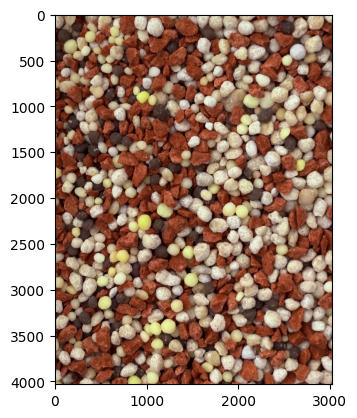

In [3]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image paths ===
folder_path_1 = "D:/2D/pictures/15-4-20"
folder_path_2 = "D:/2D/pictures/15-15-15"
folder_path_3 = "D:/2D/pictures/18-4-5"

images_path_1 = [os.path.join(folder_path_1, f) for f in os.listdir(folder_path_1) if f.lower().endswith('.jpg')]
images_path_2 = [os.path.join(folder_path_2, f) for f in os.listdir(folder_path_2) if f.lower().endswith('.jpg')]
images_path_3 = [os.path.join(folder_path_3, f) for f in os.listdir(folder_path_3) if f.lower().endswith('.jpg')]

#visualize the image (for debugging)
image_bgr = cv2.imread(images_path_1[1])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

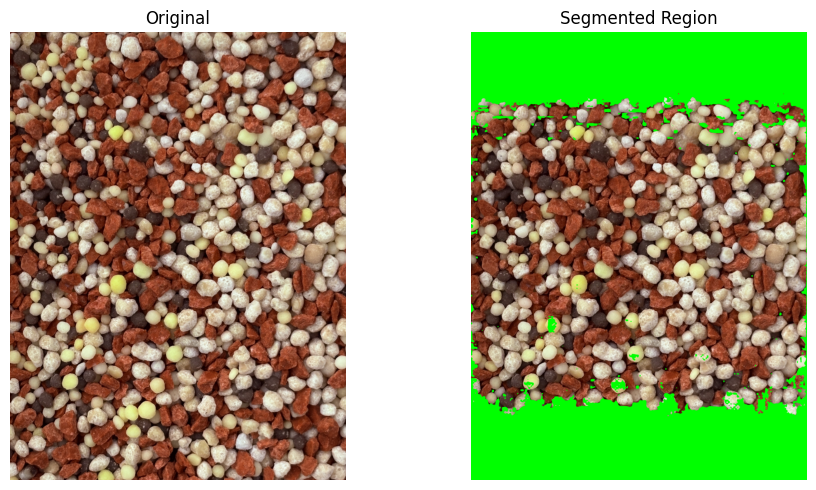

In [6]:
import torch
from segment_anything import sam_model_registry, SamPredictor

img_path = images_path_1[1] # Change to your image path

# === Load the SAM model ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"  # Path to your checkpoint file
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load and prepare the image ===
image_bgr = cv2.imread(img_path)  
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Visualize ===
mask = masks[0]

# Overlay the mask
masked_image = image_rgb.copy()
masked_image[~mask] = [0, 255, 0]  # Set everything else to black

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region")
plt.axis('off')

plt.tight_layout()
plt.show()


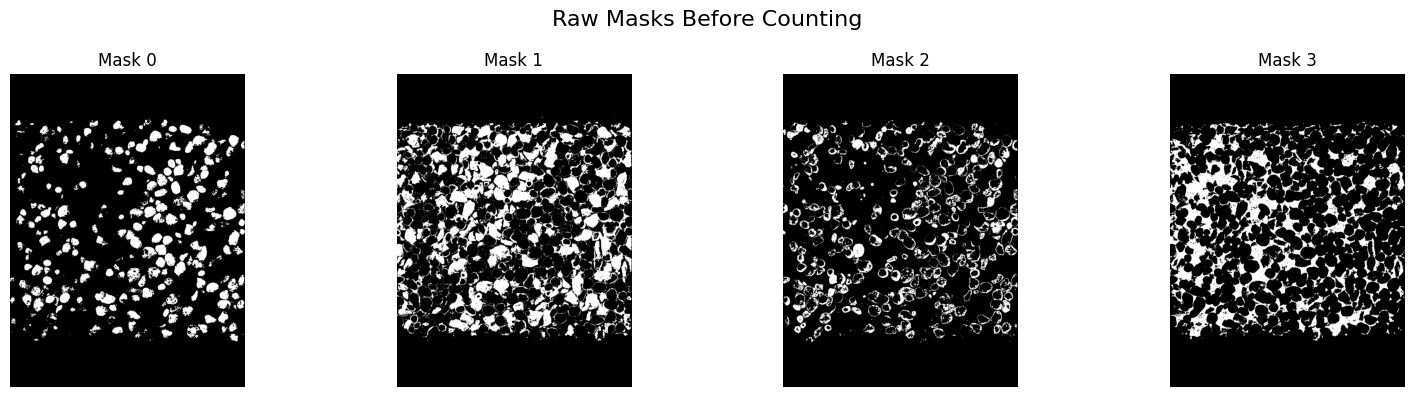

Counting beads with SAM...


Clusters: 100%|██████████| 4/4 [00:24<00:00,  6.21s/it]


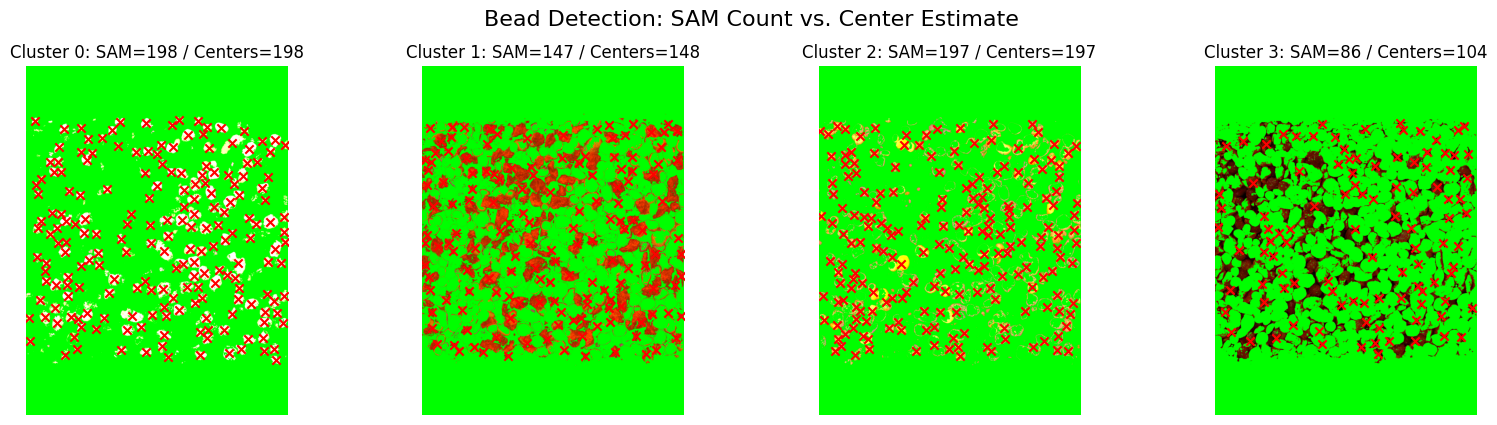


Summary:
Cluster 1: 198 beads counted by SAM from 198 estimated centers
Cluster 2: 147 beads counted by SAM from 148 estimated centers
Cluster 3: 197 beads counted by SAM from 197 estimated centers
Cluster 4: 86 beads counted by SAM from 104 estimated centers
Total SAM-counted beads: 628
Total estimated centers: 647


In [8]:
from sklearn.cluster import KMeans
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm


# === Config ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4


# === Initialize SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)


# === Function to detect bead centers using contours ===
def get_centers(mask, min_area=1500, min_dist=10):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Clean up noise slightly
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers


# === Visualize masks before counting ===
plt.figure(figsize=(16, 4))
for i, mask in enumerate(all_masks):
    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')
plt.suptitle("Raw Masks Before Counting", fontsize=16)
plt.tight_layout()
plt.show()


# === Count beads with SAM ===
print("Counting beads with SAM...")
all_counts, all_centers = [], []
predictor.set_image(enhanced_image)

for i, mask in enumerate(tqdm(all_masks, desc="Clusters")):
    centers = get_centers(mask)
    count = 0
    for x, y in centers:
        try:
            masks, scores, _ = predictor.predict(
                point_coords=np.array([[x, y]]),
                point_labels=np.array([1]),
                multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            # Adjust the value below based on output quality
            if np.sum(best_mask) > 80 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.10:
                count += 1
        except:
            continue
    all_counts.append(count)
    all_centers.append(centers)


# === Visualization ===
plt.figure(figsize=(16, 8))
for i, (mask, centers) in enumerate(zip(all_masks, all_centers)):
    cluster_img = np.full_like(enhanced_image, [0, 255, 0])
    cluster_img[mask] = enhanced_image[mask]
    plt.subplot(2, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    if centers:
        cx, cy = zip(*centers)
        plt.scatter(cx, cy, c='red', marker='x')
    plt.title(f"Cluster {i}: SAM={all_counts[i]} / Centers={len(centers)}")
    plt.axis('off')
plt.suptitle("Bead Detection: SAM Count vs. Center Estimate", fontsize=16)
plt.tight_layout()
plt.show()


print("\nSummary:")
for i, (c, centers) in enumerate(zip(all_counts, all_centers)):
    print(f"Cluster {i+1}: {c} beads counted by SAM from {len(centers)} estimated centers")
print("Total SAM-counted beads:", sum(all_counts))
print("Total estimated centers:", sum(len(c) for c in all_centers))


In [9]:
print(all_counts)

[198, 147, 197, 86]


In [10]:
def get_npk(all_counts):
    
    white_beads = all_counts[0]
    red_beads = all_counts[1]
    stain_beads = all_counts[2]
    black_beads = all_counts[3]

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(all_counts)
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(all_counts)} in percantage")

NPK Composition: {'N': 23.56, 'P': 6.3, 'K': 14.04} in percantage
